In [54]:
import random
import math
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import KFold
from scipy import stats

DATA_PATH = os.path.abspath('data')

def normalEquation_ridge(matX,vecY,lamda):
    X_transpose = np.transpose(matX)
    X_transpose_dot_X = np.dot(X_transpose,matX)
    
    diagonal_one = np.identity(X_transpose_dot_X.shape[0])
    diagonal_one[0,0] = 0

    left_side = X_transpose_dot_X + lamda*diagonal_one
    right_side = np.dot(X_transpose,vecY)

    ans = np.linalg.inv(left_side).dot(right_side)
    return ans

def generate_feature_matrix(x, degree):
    if degree == 0:
        X = np.ones((len(x), 1))
        return X
    elif degree == 1:
        X = np.column_stack((np.ones(len(x)), x))
        return X
    elif degree > 1:
        X_poly = np.column_stack([x ** d for d in range(0, degree+1)])
        return X_poly
    else:
        raise ValueError("Degree must be a non-negative integer.")
    
def Standardize(points):
    a = 0
    n = len(points)
    mean = sum(points) / n
    new_points = []
    for i in range(0,n):
        a += (points[i] - mean) ** 2
    std = math.sqrt(a / (n-1))
    for i in range(0,n):
        new_points.append((points[i] - mean) / std)
    return new_points

def CalculateSE_ridge(x_positions, y_positions, w_list, lamda):
    n = len(x_positions)
    x_positions = generate_feature_matrix(x_positions,len(w_list)-1)
    SE = 0
    for i in range(0, n):
        wx = np.dot(x_positions[i],w_list)
        SE += ((wx - y_positions[i]) ** 2)

    for j in range(len(w_list)):
        SE += lamda*w_list[j]**2
        
    return SE

def draw_regression_line(w,name,x):
    x_line = np.linspace(min(x),max(x), 100)
    y_line = w[1] * x_line + w[0]

    regression = go.Scatter(x=x_line, y=y_line, mode='lines', name=name)
    return regression

def polynomial_predictions(x, w):
    degree = len(w) - 1
    y_pred = np.zeros_like(x)
    for i in range(degree + 1):
        y_pred += w[i] * (x**i)
    return y_pred

def model_plot(x, y, w_list, label_list):
    fig = go.Figure()
    x_range = np.linspace(min(x), max(x), 100)

    for i, w in enumerate(w_list):
        y_pred = polynomial_predictions(x_range, w)
        fig.add_trace(go.Scatter(x=x_range, y=y_pred, mode='lines', name=label_list[i]))

    fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Data Points', marker=dict(color='blue')))
    #y_sin = [math.sin(math.pi*x) for x in x_range]
    #fig.add_trace(go.Scatter(x=x_range, y=y_sin, mode='lines', name="sin"))

    fig.update_layout(
        title=f'Data and Polynomial Regression {len(x)} Samples',
        xaxis_title='X',
        yaxis_title='Y',
        showlegend=True,
        width=1000,
        height=600,
        yaxis_range=[-1.5,1.5]
    )

    return fig

def CalculateMSE(x_positions, y_positions, w_list):
    n = len(x_positions)
    x_positions = generate_feature_matrix(x_positions,len(w_list)-1)
    MSE = 0

    for i in range(0, n):
        wx = np.dot(x_positions[i], w_list) #x_positon is array 1 x len(w_list) dimension Ex. [ 1 , x^1 , x^2 , ..... , x^n]
        MSE += (wx - y_positions[i]) ** 2

        
    MSE *= 1/(n)
    # print("new",MSE)
    return MSE

def cross_validation(X, y, folds, degree, lamda):
    #Not done
    k_folds = KFold(n_splits=folds)
    
    avg_rmse = []
    for train_index, validate_index in k_folds.split(X):
        # print(train_index,validate_index)
        X_train , X_validate = X.iloc[train_index], X.iloc[validate_index]
        y_train , y_validate = y.iloc[train_index], y.iloc[validate_index]

        x_feature_matrix = generate_feature_matrix(X_train.values.flatten(), degree)
        result = normalEquation_ridge(x_feature_matrix, np.array(y_train), lamda)
        
        avg_rmse.append(CalculateMSE(X_validate.values.flatten(), np.array(y_validate), result)**(1/2))
        #avg_rmse.append(CalculateMSE_poly(X_validate.values.flatten(), np.array(y_validate), result))
    return np.mean(avg_rmse)

def Standardize(points):
    a = 0
    n = len(points)
    mean = sum(points) / n
    new_points = []
    for i in range(0,n):
        a += (points[i] - mean) ** 2
    std = math.sqrt(a / (n-1))
    for i in range(0,n):
        new_points.append((points[i] - mean) / std)
    return new_points

def random_linear_model(target_func, n=2, noisy=0, sigma=0.1, seed=1):
    mu = 0 # mean and standard deviation
    np.random.seed(seed)
    noise = np.random.normal(mu, sigma, n)
    x = [float(random.uniform(-1.0,1.0)) for i in range(n)]
    #y = [math.sin(x[i]*math.pi)+(noise[i]*noisy) for i in range(n)]
    y = target_func(x, noise, noisy)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return (float(intercept), float(slope), x, y)

def random_linear_model_ridge(target_func, n=2,  noisy=0, sigma=0.1, seed=1, lamda=0, degree=1):
    mu = 0 # mean and standard deviation
    np.random.seed(seed)
    noise = np.random.normal(mu, sigma, n)
    x = [float(random.uniform(-1.0,1.0)) for i in range(n)]
    #y = [math.sin(x[i]*math.pi)+(noise[i]*noisy) for i in range(n)]
    y = target_func(x, noise, noisy)
    x_feature_matrix = generate_feature_matrix(x, degree)
    w = normalEquation_ridge(x_feature_matrix, y, lamda)
    return w

def abline(slope, intercept, color, linewidth = 0.1):
    """Plot a line from slope and intercept"""
    x_vals = np.linspace(-1, 1, 1000)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color=color, linewidth = linewidth)

def var_one_model(slope, intercept, slope_avg, intercept_avg):
    # only one model
    x_vals = np.linspace(-1, 1, 1000)
    var_list = []
    for x in x_vals:
        y_model = slope*x + intercept
        y_avg = slope_avg*x + intercept_avg
        var_list.append((y_model - y_avg)**2)
    return np.array(var_list)

def var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg):
    variance_list = []
    var_list = []
    for i in range(len(slope_sample)):
        slope = slope_sample[i]
        intercept = intercept_sample[i]
        var = var_one_model(slope, intercept, slope_avg, intercept_avg)
        var_list.append(var)
        variance_list.append(np.average(var))
    return variance_list , sum(var_list)/len(var_list)

def bias_linear_model(slope_avg,intercept_avg,target_func):
    x_vals = np.linspace(-1, 1, 1000)
    bias = 0
    for x in x_vals:
        bias += ((slope_avg*x + intercept_avg) - target_func([x],[0],0)[0])**2
    bias /= len(x_vals)
    return bias

In [68]:
def sin_pi(x, noise, noisy):
    return [math.sin(x[i]*math.pi)+(noise[i]*noisy) for i in range(len(x))]

def new_func(x, noise, noisy):
    return [(1/2) * abs(math.sin(2 * x[i] * math.pi)) + 0.25*x[i] + 0.25 + +(noise[i]*noisy) for i in range(len(x))]

def cos_pi(x, noise, noisy):
    return [math.cos(x[i]*math.pi)+(noise[i]*noisy) for i in range(len(x))]

In [74]:
# without Regularize
# Pick 2 random points to create n models and average them
n = 5000
slope_sample = []
intercept_sample = []
for i in range(n):
    intercept, slope = random_linear_model_ridge(target_func=cos_pi, lamda=math.exp(-2))[0:2]
    slope_sample.append(slope)
    intercept_sample.append(intercept)

In [75]:
slope_avg = np.average(slope_sample)
intercept_avg = np.average(intercept_sample)
print("slope_avg:", slope_avg)
print("intercept_avg:", intercept_avg)

slope_avg: 0.007730437180649419
intercept_avg: 0.2543440701575662


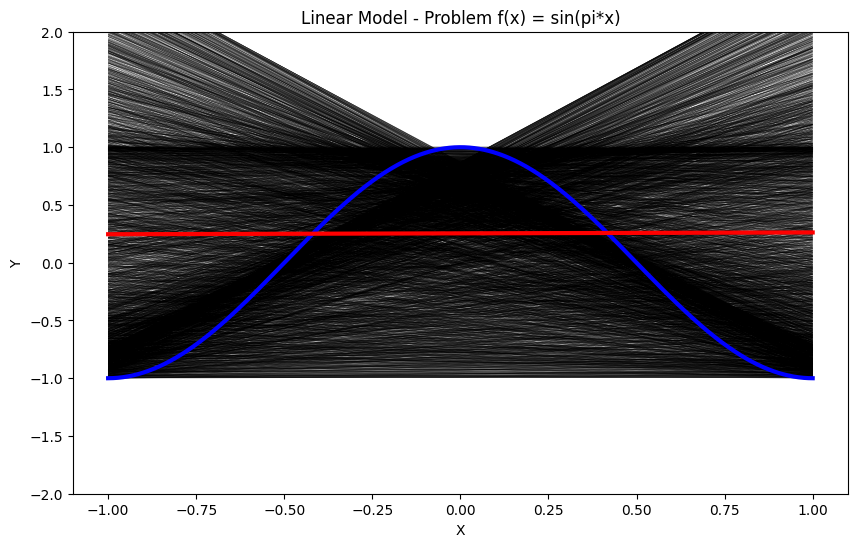

In [76]:
plt.figure(figsize=(10,6))
plt.ylim(-2,2)
plt.title("Linear Model - Problem f(x) = sin(pi*x)")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for i in range(len(slope_sample)):
    abline(slope_sample[i], intercept_sample[i], 'k')

# Sin graph
x_vals = np.linspace(-1, 1, 1000)
y_vals = cos_pi(x_vals,[0] * 1000, 0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'r', 3)

In [77]:
var_linear_model_list = var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)
bias = bias_linear_model(slope_avg, intercept_avg, sin_pi)
print("var:", np.average(var_linear_model_list[0]))
print("bias:", bias)

var: 0.5371602307217279
bias: 0.5592944541880219


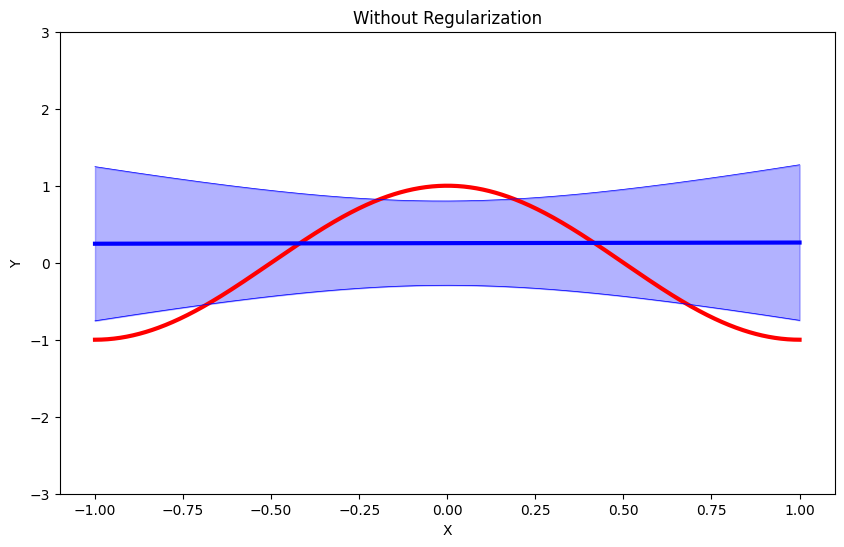

In [78]:
plt.figure(figsize=(10,6))
plt.ylim(-3,3)
plt.title("Without Regularization")
plt.xlabel("X")
plt.ylabel("Y")

# Sin graph
x_vals = np.linspace(-1, 1, 1000)
y_vals = cos_pi(x_vals,[0]*1000,0)
plt.plot(x_vals, y_vals, '-', color='r', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'b', 3)
g_bar = intercept_avg + slope_avg * x_vals

var1 = (var_linear_model_list[1]**(1/2)) + np.array(g_bar)
plt.plot(x_vals, var1, '-', color='b', linewidth=0.5)

var2 = np.array(g_bar) - (var_linear_model_list[1]**(1/2))
plt.plot(x_vals, var2, '-', color='b', linewidth=0.5)
plt.fill_between(x_vals, var2, var1, color='b', alpha=0.3)
#plt.fill_between(x_vals, var1, color='b', alpha=0.5)